<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


<h1>Training A Neural Network with Momentum</h1>


<h3>Objective for this Notebook<h3>    
<h5> 1. Train Different Neural Networks Model different values for the Momentum Parameter.</h5>
<h5> 2. Compare Results of Different Momentum Terms. </h5>     


<h2>Table of Contents</h2>
<p>In this lab, you will see how different values for the momentum parameters affect the convergence rate of a neural network.</p>

<ul>
<li><a href="#Model">Neural Network Module and Function for Training</a></li>
<li><a href="#Train">Train Different Neural Networks Model different values for the Momentum Parameter</a></li>
<li><a href="#Result">Compare Results of Different Momentum Terms</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>

<hr>


<h2>Preparation</h2>


We'll need the following libraries:


In [1]:
# Import the libraries for this lab

# Used to graph data and loss curves
import matplotlib.pyplot as plt 
# Allows us to use arrays to manipulate and store data
import numpy as np
# PyTorch Library
import torch
# PyTorch Neural Network
import torch.nn as nn
# Allows us to use activation functions
import torch.nn.functional as F
# Used to graph data and loss curves
from matplotlib.colors import ListedColormap
# Used to help create the dataset and perform mini-batch
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1)
np.random.seed(1)

Functions used to plot:


In [2]:
# Define a function to plot the decision region

def plot_decision_regions_3class(model, data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00','#00AAFF'])
    X=data_set.x.numpy()
    y=data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1 , X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1 , X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    XX=torch.torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    _,yhat=torch.max(model(XX),1)
    yhat=yhat.numpy().reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light, shading='auto')
    plt.plot(X[y[:]==0,0], X[y[:]==0,1], 'ro', label='y=0')
    plt.plot(X[y[:]==1,0], X[y[:]==1,1], 'go', label='y=1')
    plt.plot(X[y[:]==2,0], X[y[:]==2,1], 'o', label='y=2')
    plt.title("decision region")
    plt.legend()

Create the dataset class: We will display the dataset later below


In [3]:
# Create the dataset class

class Data(Dataset):
    
    # modified from: http://cs231n.github.io/neural-networks-case-study/
    # Constructor
    def __init__(self, K=3, N=500):
        D = 2
        X = np.zeros((N * K, D)) # data matrix (each row = single example)
        y = np.zeros(N * K, dtype='uint8') # class labels
        for j in range(K):
          ix = range(N * j, N * (j + 1))
          r = np.linspace(0.0, 1, N) # radius
          t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
          X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
          y[ix] = j
    
        self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.x = torch.from_numpy(X).type(torch.FloatTensor)
        self.len = y.shape[0]
            
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot_data(self):
        plt.plot(self.x[self.y[:] == 0, 0].numpy(), self.x[self.y[:] == 0, 1].numpy(), 'o', label="y=0")
        plt.plot(self.x[self.y[:] == 1, 0].numpy(), self.x[self.y[:] == 1, 1].numpy(), 'ro', label="y=1")
        plt.plot(self.x[self.y[:] == 2, 0].numpy(),self.x[self.y[:] == 2, 1].numpy(), 'go',label="y=2")
        plt.legend()

<!--Empty Space for separating topics-->


<h2 id="Model">Neural Network Module and Function for Training</h2>


Create Neural Network Module using <code>ModuleList()</code>


In [4]:
# Create dataset object

class Net(nn.Module):
    
    # Constructor
    # Given a list of integers, Layers, we create layers of the neural network where each integer in Layers corresponds to the layers number of neurons
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
    
    # Prediction
    # Puts the X value through each layer of the neural network while using the RELU activation function in between. The final output is not put through RELU.
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = F.relu(linear_transform(x))    
            else:
                x = linear_transform(x)
        return x

Create the function for training the model.


In [5]:
# Define the function for training the model

def train(data_set, model, criterion, train_loader, optimizer, epochs=100):
    # Lists to keep track of loss and accuracy
    LOSS = []
    ACC = []
    # Number of times we train on the entire dataset
    for epoch in range(epochs):
        # For batch in train laoder
        for x, y in train_loader:
            # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
            optimizer.zero_grad()
            # Makes a prediction based on X value
            yhat = model(x)
            # Measures the loss between prediction and acutal Y value
            loss = criterion(yhat, y)
            # Calculates the gradient value with respect to each weight and bias
            loss.backward()
            # Updates the weight and bias according to calculated gradient value
            optimizer.step()
        # Saves loss and accuracy
        LOSS.append(loss.item())
        ACC.append(accuracy(model,data_set))
        
    # Prints the Loss and Accuracy vs Epoch graph
    results ={"Loss":LOSS, "Accuracy":ACC}
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(LOSS,color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis = 'y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()
    return results

Define a function used to calculate accuracy.


In [6]:
# Define a function for calculating accuracy

def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x), 1)
    return (yhat == data_set.y).numpy().mean()

<!--Empty Space for separating topics-->


<h2 id="Train">Train Different Networks Model different values for the Momentum Parameter</h2>


Create a dataset object using <code>Data</code>


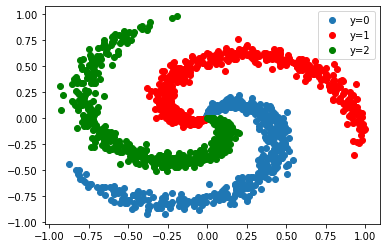

In [7]:
# Create the dataset and plot it

data_set = Data()
data_set.plot_data()
data_set.y = data_set.y.view(-1)

Dictionary to contain different cost and  accuracy values for each epoch  for different values of the momentum parameter.


In [8]:
# Initialize a dictionary to contain the cost and accuracy

Results = {"momentum 0": {"Loss": 0, "Accuracy:": 0}, "momentum 0.1": {"Loss": 0, "Accuracy:": 0}}

Create a  network to classify three classes with 1 hidden layer with 50 neurons and a momentum value of zero.


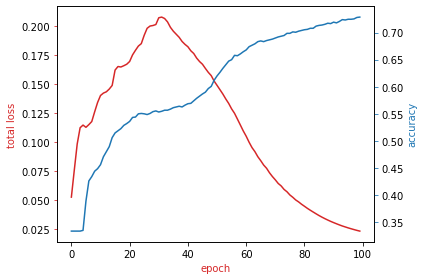

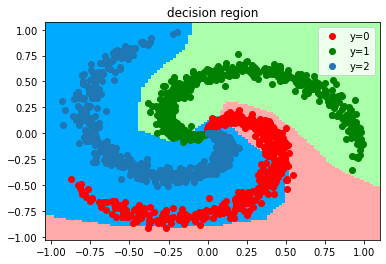

In [9]:
# Train a model with 1 hidden layer and 50 neurons

# Size of input layer is 2, hidden layer is 50, and output layer is 3
# Our X values are x and y coordinates and this problem has 3 classes
Layers = [2, 50, 3]
# Create a model
model = Net(Layers)
learning_rate = 0.10
# Create an optimizer that updates model parameters using the learning rate, gradient, and no momentum
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# Create a Data Loader for the training data with a batch size of 20
train_loader = DataLoader(dataset=data_set, batch_size=20)
# We create a criterion which will measure loss
criterion = nn.CrossEntropyLoss()
# Use the training function to train the model for 100 epochs
Results["momentum 0"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)
# Prints the dataset and decision boundaries
plot_decision_regions_3class(model, data_set)

Create a network to classify three classes with 1 hidden layer with 50 neurons and a momentum value of 0.1.


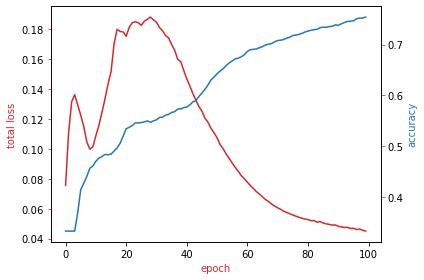

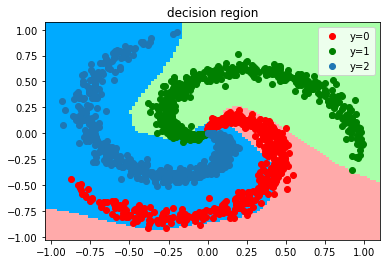

In [10]:
# Train a model with 1 hidden layer and 50 neurons with 0.1 momentum

# Size of input layer is 2, hidden layer is 50, and output layer is 3
# Our X values are x and y coordinates and this problem has 3 classes
Layers = [2, 50, 3]
# Create a model
model = Net(Layers)
learning_rate = 0.10
# Create an optimizer that updates model parameters using the learning rate, gradient, and 0.1 momentum
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.1)
# Create a Data Loader for the training data with a batch size of 20
train_loader = DataLoader(dataset=data_set, batch_size=20)
# We create a criterion which will measure loss
criterion = nn.CrossEntropyLoss()
# Use the training function to train the model for 100 epochs
Results["momentum 0.1"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)
# Prints the dataset and decision boundaries
plot_decision_regions_3class(model, data_set)

Create a network to classify three classes with 1 hidden layer with 50 neurons and a momentum value of 0.2.


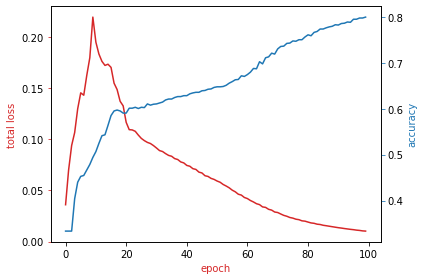

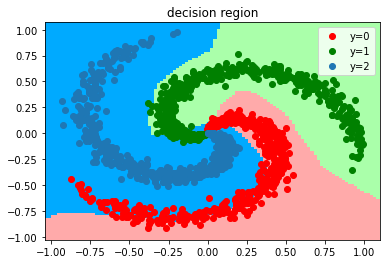

In [11]:
# Train a model with 1 hidden layer and 50 neurons with 0.2 momentum

# Size of input layer is 2, hidden layer is 50, and output layer is 3
# Our X values are x and y coordinates and this problem has 3 classes
Layers = [2, 50, 3]
# Create a model
model = Net(Layers)
learning_rate = 0.10
# Create an optimizer that updates model parameters using the learning rate, gradient, and 0.2 momentum
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.2)
# Create a Data Loader for the training data with a batch size of 20
train_loader = DataLoader(dataset=data_set, batch_size=20)
# We create a criterion which will measure loss
criterion = nn.CrossEntropyLoss()
# Use the training function to train the model for 100 epochs
Results["momentum 0.2"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)
# Prints the dataset and decision boundaries
plot_decision_regions_3class(model, data_set)

Create a network to classify three classes with 1 hidden layer with 50 neurons and a momentum value of 0.4.


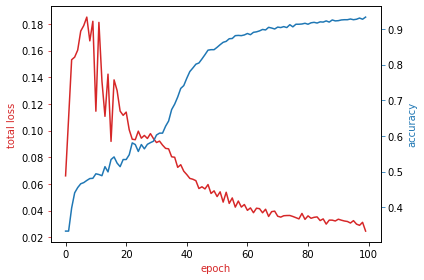

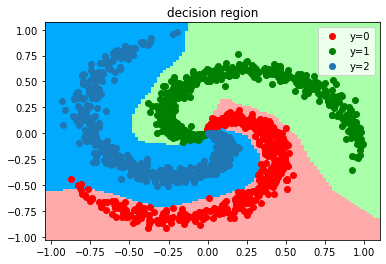

In [12]:
# Train a model with 1 hidden layer and 50 neurons with 0.4 momentum

# Size of input layer is 2, hidden layer is 50, and output layer is 3
# Our X values are x and y coordinates and this problem has 3 classes
Layers = [2, 50, 3]
# Create a model
model = Net(Layers)
learning_rate = 0.10
# Create an optimizer that updates model parameters using the learning rate, gradient, and 0.4 momentum
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.4)
# Create a Data Loader for the training data with a batch size of 20
train_loader = DataLoader(dataset=data_set, batch_size=20)
# We create a criterion which will measure loss
criterion = nn.CrossEntropyLoss()
# Use the training function to train the model for 100 epochs
Results["momentum 0.4"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)
# Prints the dataset and decision boundaries
plot_decision_regions_3class(model, data_set)

Create a network to classify three classes with 1 hidden layer with 50 neurons and a momentum value of 0.5.


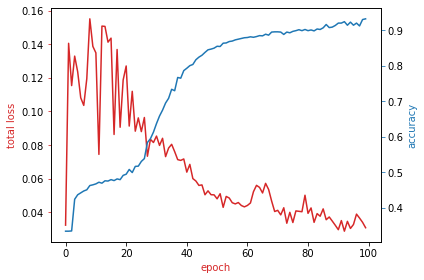

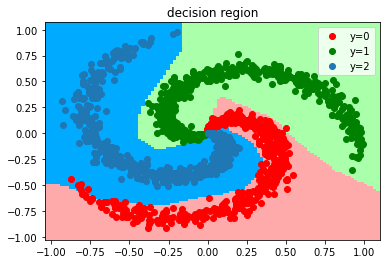

In [13]:
# Train a model with 1 hidden layer and 50 neurons with 0.5 momentum

# Size of input layer is 2, hidden layer is 50, and output layer is 3
# Our X values are x and y coordinates and this problem has 3 classes
Layers = [2, 50, 3]
# Create a model
model = Net(Layers)
learning_rate = 0.10
# Create an optimizer that updates model parameters using the learning rate, gradient, and 0.5 momentum
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)
# Create a Data Loader for the training data with a batch size of 20
train_loader = DataLoader(dataset=data_set, batch_size=20)
# We create a criterion which will measure loss
criterion = nn.CrossEntropyLoss()
# Use the training function to train the model for 100 epochs
Results["momentum 0.5"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)
# Prints the dataset and decision boundaries
plot_decision_regions_3class(model, data_set)

<!--Empty Space for separating topics-->


<h2 id="Result">Compare Results of Different Momentum Terms</h2>


The plot below compares the results of different momentum terms. We see that in general. The Cost decreases proportionally to the momentum term, but larger momentum terms lead to larger oscillations. While the momentum term decreases faster, it seems that a momentum term of 0.2 reaches the smallest value for the cost.


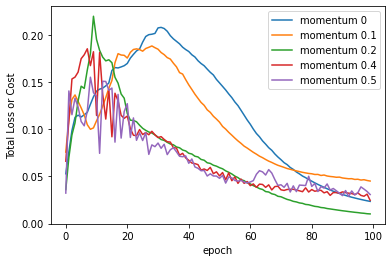

In [14]:
# Plot the Loss result for each term

for key, value in Results.items():
    plt.plot(value['Loss'],label=key)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('Total Loss or Cost')

The  accuracy seems to be proportional to the momentum term.


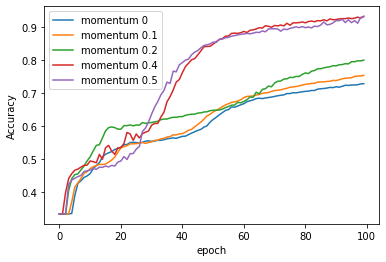

In [15]:
# Plot the Accuracy result for each term

for key, value in Results.items():
    plt.plot(value['Accuracy'],label=key)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')

<a href="https://dataplatform.cloud.ibm.com/registration/stepone?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera25797139-2021-01-01&context=cpdaas&apps=data_science_experience%2Cwatson_machine_learning"><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/Watson_Studio.png"/></a>


<!--Empty Space for separating topics-->


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera25797139-2021-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera25797139-2021-01-01">Michelle Carey</a>, <a href="https://www.linkedin.com/in/jiahui-mavis-zhou-a4537814a?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera25797139-2021-01-01">Mavis Zhou</a>


## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-23  | 2.0  | Srishti  |  Migrated Lab to Markdown and added to course repo in GitLab |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
